In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [4]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

## TASK 1

### 1) Who are the top and bottom 10  users by 

In [5]:
### Parsing Data
data_directory = os.path.join(rpath, "data")
slack_data_loader = SlackDataLoader(data_directory)
# List all directories in the 'data' directory
directories = [d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, d))]


dfs_by_directory = []

# Iterate through each directory
for directory in directories:
    directory_path = os.path.join(data_directory, directory)
    df_directory = slack_data_loader.slack_parser(directory_path)
    
    # Add a 'directory' column to identify the source directory
    df_directory['directory'] = directory
    
    # Append the DataFrame to the list
    dfs_by_directory.append(df_directory)

# Concatenate all DataFrames into a single DataFrame
slack_parser_df = pd.concat(dfs_by_directory, ignore_index=True)
slack_parser_df.head(5)

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel,directory
0,message,"Hi guys,\nI thought having a group chat would ...",Anita Rodriguez,1661766066.863109,text,0,0,0,0,0,c:\Users\user\Desktop\10 academy\Slack_message...,ab_test-group
1,message,good!!,Michael Gonzalez,1661766159.852649,text,0,0,0,0,0,c:\Users\user\Desktop\10 academy\Slack_message...,ab_test-group
2,message,Thanks <@U03U9FWPNCE>,Robert Carter,1661766226.215889,text,0,0,0,0,0,c:\Users\user\Desktop\10 academy\Slack_message...,ab_test-group
3,message,Nice <@U03U9FWPNCE>,Phillip Atkins,1661766241.597379,text,0,0,0,0,0,c:\Users\user\Desktop\10 academy\Slack_message...,ab_test-group
4,message,I have been missing deadlines and I am trying ...,Anita Rodriguez,1661766295.939119,text,0,0,0,0,0,c:\Users\user\Desktop\10 academy\Slack_message...,ab_test-group


#### a) by reply count

In [6]:

# TOP 10 users by reply count
Top_10_users_by_replies = slack_parser_df.groupby('sender_name')['reply_users_count'].sum().reset_index(name='Top_10_users_by_replies').sort_values(by='Top_10_users_by_replies', ascending=False).head(10)

Top_10_users_by_replies

,sender_name,Top_10_users_by_replies
15,Cristian Wilson,311
57,Vanessa Norman,276
42,Michelle Lewis,193
8,Brenda Hernandez,179
9,Brian Odom,171
56,Travis Butler,162
4,April Lucas,153
1,Amy Leon,151
30,Joshua Rhodes,143
49,Phillip Atkins,138


In [7]:
# BOTTOM 10 users by reply count
Bottom_10_users_by_replies = slack_parser_df.groupby('sender_name')['reply_users_count'].sum().reset_index(name='Bottom_10_users_by_replies').sort_values(by='Bottom_10_users_by_replies', ascending=True).head(10)

Bottom_10_users_by_replies

,sender_name,Bottom_10_users_by_replies
22,Erica Munoz,0
46,Patricia Thomas,0
6,Blake Scott,0
54,Slackbot,0
47,Patrick Hernandez,0
25,Holly Whitaker,0
17,David Scott,0
14,Christopher Case,0
35,Leah Newton,2
50,Randy Miller,3


#### b) by mentions

In [24]:
mention_count = slack_parser_df['msg_content'].apply(lambda x: len(re.findall(r'@U\w+', x)))
filtered_df = slack_parser_df[slack_parser_df['msg_content'].str.contains('@U', regex=True)]

#TOP 10 users by mentions
Top_10_users_by_mentions = mention_count.groupby(slack_parser_df['sender_name']).sum().reset_index(name='Top_10_users_by_mentions').sort_values(by='Top_10_users_by_mentions', ascending=False).head(10)
Top_10_users_by_mentions

,sender_name,Top_10_users_by_mentions
57,Vanessa Norman,532
4,April Lucas,214
15,Cristian Wilson,206
7,Brady Rhodes,184
56,Travis Butler,181
1,Amy Leon,158
8,Brenda Hernandez,147
49,Phillip Atkins,139
31,Judith Bolton,130
9,Brian Odom,113


In [25]:
#BOTTOM 10 users by mentions
Bottom_10_users_by_mentions = mention_count.groupby(slack_parser_df['sender_name']).sum().reset_index(name='Bottom_10_users_by_mentions').sort_values(by='Bottom_10_users_by_mentions', ascending=True).head(10)
Bottom_10_users_by_mentions

,sender_name,Bottom_10_users_by_mentions
54,Slackbot,0
6,Blake Scott,0
25,Holly Whitaker,0
22,Erica Munoz,0
50,Randy Miller,0
17,David Scott,0
14,Christopher Case,0
46,Patricia Thomas,0
35,Leah Newton,1
47,Patrick Hernandez,1


#### c) by messages

In [27]:
# Top 10 users by messages
Top_10_users_by_messages = slack_parser_df.groupby('sender_name').size().reset_index(name='Top_10_users_by_messages').sort_values(by='Top_10_users_by_messages', ascending=False).head(10)
Top_10_users_by_messages

,sender_name,Top_10_users_by_messages
57,Vanessa Norman,1288
1,Amy Leon,1150
56,Travis Butler,1075
4,April Lucas,991
8,Brenda Hernandez,843
15,Cristian Wilson,831
49,Phillip Atkins,754
7,Brady Rhodes,641
31,Judith Bolton,574
30,Joshua Rhodes,519


In [28]:
# Bottom 10 users by messages
Bottom_10_users_by_messages = slack_parser_df.groupby('sender_name').size().reset_index(name='Bottom_10_users_by_messages').sort_values(by='Bottom_10_users_by_messages', ascending=True).head(10)
Bottom_10_users_by_messages

,sender_name,Bottom_10_users_by_messages
6,Blake Scott,1
22,Erica Munoz,1
17,David Scott,1
25,Holly Whitaker,1
14,Christopher Case,1
54,Slackbot,3
47,Patrick Hernandez,5
50,Randy Miller,7
46,Patricia Thomas,8
35,Leah Newton,10


#### d) by reactions

In [30]:
data_directory = os.path.join(rpath, "data")
slack_data_loader = SlackDataLoader(data_directory)
# List all directories in the 'data' directory
directories = [d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, d))]


df_by_directory = []

# Iterate through each directory
for directory in directories:
    directory_path = os.path.join(data_directory, directory)
    df_directory = slack_data_loader.parse_slack_reaction(directory_path)
    
    # Add a 'directory' column to identify the source directory
    df_directory['directory'] = directory
    
    # Append the DataFrame to the list
    df_by_directory.append(df_directory)

# Concatenate all DataFrames into a single DataFrame
reaction_df = pd.concat(df_by_directory, ignore_index=True)

users_df= pd.DataFrame(slack_data_loader.get_users())
users_df.rename(columns={'id':'user_id'}, inplace = True)

reactions_merged = pd.merge(reaction_df, users_df, on='user_id', how='outer')


In [31]:
# TOP 10 users by reaction count
Top_10_users_by_reactions = reactions_merged.groupby('real_name')['reaction_count'].sum().reset_index(name='Top_10_users_by_reactions').sort_values(by='Top_10_users_by_reactions', ascending=False).head(10)
Top_10_users_by_reactions

,real_name,Top_10_users_by_reactions
66,Vanessa Norman,1124
4,April Lucas,625
1,Amy Leon,573
36,Judith Bolton,536
18,Cristian Wilson,509
9,Brady Rhodes,448
65,Travis Butler,440
58,Phillip Atkins,428
11,Brian Odom,424
37,Katherine Foster,383


In [32]:
# BOTTOM 10 users by reaction count
Bottom_10_users_by_reactions = reactions_merged.groupby('real_name')['reaction_count'].sum().reset_index(name='Bottom_10_users_by_reactions').sort_values(by='Bottom_10_users_by_reactions', ascending=True).head(10)
Bottom_10_users_by_reactions

,real_name,Bottom_10_users_by_reactions
26,Erica Munoz,0
56,Paul Brown,0
38,Kathleen Phillips,0
21,David Scott,0
19,Dana Parks,0
61,Ryan Cochran,0
17,Claudia Riddle,0
41,Kenneth Fitzgerald,0
30,Holly Whitaker,0
29,Glen Pennington,0


### 2) What are the top 10 messages by

#### a) Replies?

In [15]:

# TOP 10 messages by replies
top_10_message_by_replies= slack_parser_df.groupby('msg_content').size().reset_index(name='total_reply_count').sort_values(by='total_reply_count', ascending=False)
top_10_message_by_replies.head(10)

,msg_content,total_reply_count
5780,Hello,150
15582,yes,89
13076,hello,57
11574,Yes,57
927,:rolling_on_the_floor_laughing:,40
5991,Hi,35
265,*Independent challenge work Reminder!! <!here>...,33
5440,Good morning,33
10120,Thanks,27
730,:+1:,26


#### b) Reactions?

In [16]:

# TOP 10 messages by reactions
top_10_message_by_reactions = reactions_merged.groupby('message').size().reset_index(name='total_reaction_count').sort_values(by='total_reaction_count', ascending=False)
top_10_message_by_reactions

,message,total_reaction_count
0,,175
1211,Done,8
553,<@U03UJGP0C68> <@U03UUR571A5> <@U03V785NLSU> p...,7
322,<!channel>\nThere will be no careers exercise ...,7
99,*Independent challenge work Reminder!! <!here>...,5
...,...,...
1733,I guess it's the same girl u said yesterday:ro...,1
1734,I guessed that too,1
1735,"I had a power cut before laughing, i am back ...",1
1736,I had the same issue until I cleared the cache...,1


#### c) Mentions?

In [17]:
# Top 10 messages by mentions
top_10_message_by_mentions = filtered_df.groupby('msg_content').size().reset_index(name='mentions_count').sort_values(by='mentions_count', ascending=False)
top_10_message_by_mentions

,msg_content,mentions_count
225,<@U03TEPYRM2P>,6
367,<@U03U93GNNVB>,6
1288,<@U03V1AM5TFA>,6
992,<@U03UKL27B0R>,6
1050,<@U03UP7V9Q57>,4
...,...,...
833,<@U03UJGP0C68> Did you find the solution ??,1
834,"<@U03UJGP0C68> During the session, you raised ...",1
835,<@U03UJGP0C68> How did you get your `DBT_PROJE...,1
836,<@U03UJGP0C68> How? I would really like to know,1


### 3) Which channel has the highest activity? 

The channel with the highest activity is: c:\Users\user\Desktop\10 academy\Slack_message_analysis\data\all-community-building


C:\Users\user\AppData\Local\Temp\ipykernel_2584\3414172253.py:46: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



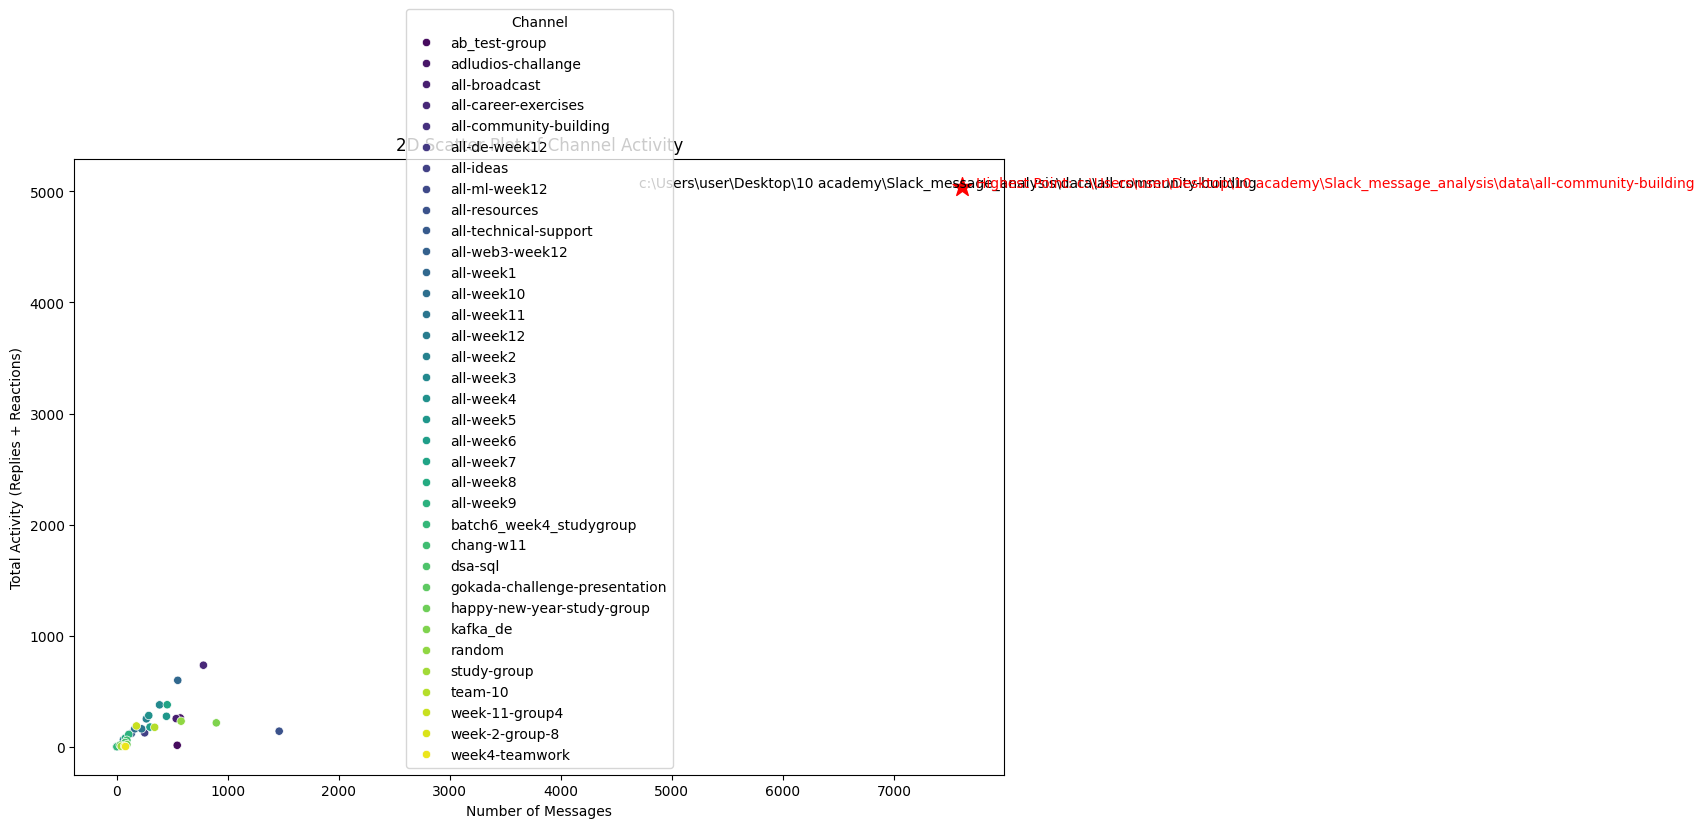

In [18]:


if not slack_parser_df.empty:
    # Calculate the total activity (sum of messages, replies, and reactions) for each channel
    required_columns = ['channel', 'msg_content', 'reply_count', 'reply_users_count']
    missing_columns = [col for col in required_columns if col not in slack_parser_df.columns]

    if missing_columns:
        print(f"Error: The following required columns are missing in the DataFrame: {missing_columns}")
    else:
        # Proceed with the groupby operation
        channel_activity = slack_parser_df.groupby('channel').agg({
            'msg_content': 'count',
            'reply_count': 'sum',
            'reply_users_count': 'sum'
        }).reset_index()

        # Calculate the total activity score (sum of replies and reactions)
        channel_activity['total_activity'] = channel_activity['reply_count'] + channel_activity['reply_users_count']

        if not channel_activity.empty:
            # Find the channel with the highest activity
            most_active_channel = channel_activity.loc[channel_activity['total_activity'].idxmax()]
            print(f"The channel with the highest activity is: {most_active_channel['channel']}")

            # Plot a 2D scatter plot using Matplotlib and Seaborn
            plt.figure(figsize=(12, 8))
            sns.scatterplot(data=channel_activity, x='msg_content', y='total_activity', hue='channel', palette='viridis')

            # Annotate the point at the top right corner
            top_right_channel = channel_activity.loc[channel_activity['msg_content'].idxmax()]
            plt.annotate(f"{top_right_channel['channel']}",
                        (top_right_channel['msg_content'], top_right_channel['total_activity']),
                        textcoords="offset points", xytext=(-10, 0), ha='center')

            # Identify and annotate the highest point
            highest_point = channel_activity.loc[channel_activity['total_activity'].idxmax()]
            plt.scatter(highest_point['msg_content'], highest_point['total_activity'], color='red', marker='*', s=200)
            plt.annotate(f"Highest Point: {highest_point['channel']}",
                         (highest_point['msg_content'], highest_point['total_activity']),
                         textcoords="offset points", xytext=(10, 0), ha='left', color='red', fontsize=10)

            plt.title("2D Scatter Plot of Channel Activity")
            plt.xlabel("Number of Messages")
            plt.ylabel("Total Activity (Replies + Reactions)")

            # Extract legend titles from the legend handles
            legend_handles, legend_labels = plt.gca().get_legend().legendHandles, plt.gca().get_legend().get_texts()
            legend_titles = [os.path.basename(label.get_text()) for label in legend_labels]

            # Update legend
            plt.legend(legend_handles, legend_titles, title='Channel')

            plt.show()
        else:
            print("Error: The channel_activity DataFrame is empty.")
else:
    print("Error: The main DataFrame (df) is empty.")


### 4) What fraction of messages are replied within the first 5mins?

C:\Users\user\AppData\Local\Temp\ipykernel_2584\3455151710.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



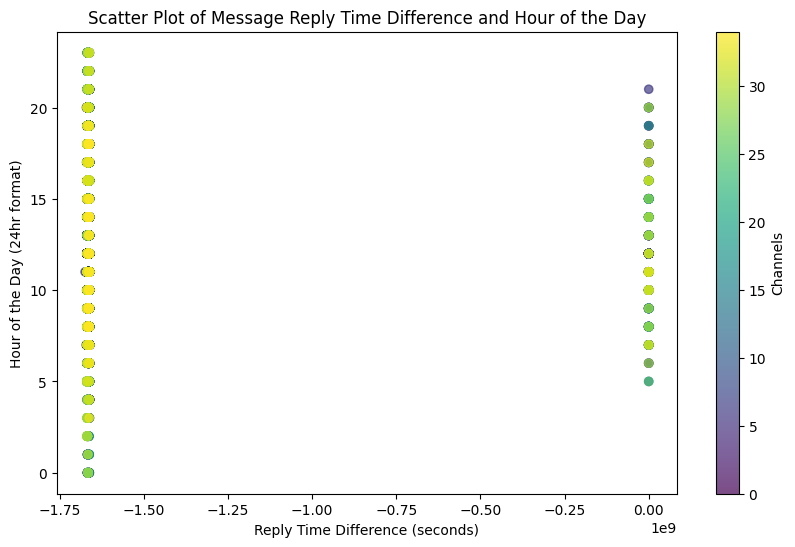

In [19]:
# Step 1: Calculate the Time Difference
slack_parser_df['msg_sent_time'] = utils.convert_2_timestamp('msg_sent_time', slack_parser_df)
slack_parser_df['time_thread_start'] = utils.convert_2_timestamp('time_thread_start', slack_parser_df)
slack_parser_df['tm_thread_end'] = utils.convert_2_timestamp('tm_thread_end', slack_parser_df)

# Calculate 'reply_time_diff' before filtering
slack_parser_df['reply_time_diff'] = (slack_parser_df['tm_thread_end'] - slack_parser_df['msg_sent_time']).dt.total_seconds()

# Filter Messages Replied Within the First 5 Minutes
replied_within_5mins = slack_parser_df[slack_parser_df['reply_time_diff'] <= 300]  # 300 seconds = 5 minutes

# Extract Hour of the Day
replied_within_5mins['hour_of_day'] = replied_within_5mins['msg_sent_time'].dt.hour

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    replied_within_5mins['reply_time_diff'],
    replied_within_5mins['hour_of_day'],
    c=replied_within_5mins['channel'].astype('category').cat.codes.tolist(),
    cmap='viridis',
    alpha=0.7
)

plt.colorbar(scatter, label='Channels')
plt.title('Scatter Plot of Message Reply Time Difference and Hour of the Day')
plt.xlabel('Reply Time Difference (seconds)')
plt.ylabel('Hour of the Day (24hr format)')

# Adjust axis limits if needed
# plt.xlim(0, 600)  # Adjust the x-axis limits if necessary

plt.show()

## TASK 2

### 1) Time differences between messages

In [37]:
def time_difference(df):
    df = df.sort_values(by='msg_sent_time', ascending=True)
    df['time_sent'] = utils.convert_2_timestamp('msg_sent_time', df)
    df['time_difference_seconds'] = df['time_sent'].diff().dt.total_seconds()  # Calculate time difference in seconds
    
    plt.hist(df['time_difference_seconds'].dropna(), bins=20, edgecolor='black')
    
    plt.xlabel('Time Difference (in seconds)')  # Update the label
    plt.ylabel('Frequency')
    plt.title('Distribution of message time difference')
    
    return plt.show()  # Use plt.show() if you want to display the plot immediately
    

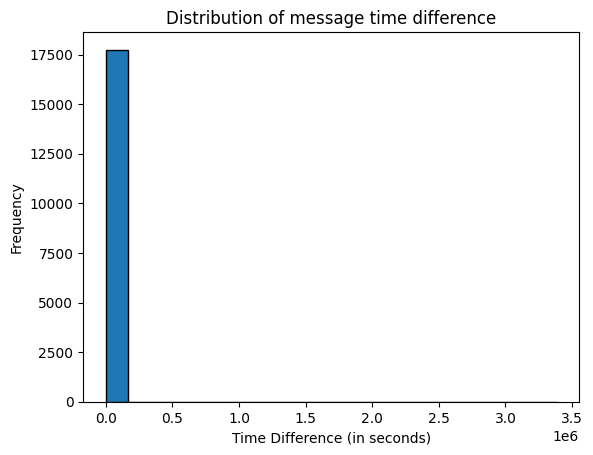

In [38]:
time_difference(slack_parser_df)